# Prepatation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re, json
from dotenv import load_dotenv
load_dotenv(".env")


import torch
from utils import ModelAndTokenizer, plot_scores, find_token_range
import matplotlib.pyplot as plt
import numpy as np
from causal_trace import plot_all_flow

torch.set_grad_enabled(False)

/home/zijianwang/miniconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zijianwang/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"  
device = "cuda:0"
mt = ModelAndTokenizer(model_name, device)

/home/zijianwang/miniconda3/envs/llm/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]
/home/zijianwang/miniconda3/envs/llm/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Case1 (Country) (Capital,Currency,Area,Population,Religion,Language)

## 1.Location by CT

In [4]:
id = 8
data_path = "country_capital_city.json"
with open(data_path, 'r') as file:
    data = json.load(file)
Template = data["Prompt"]
relation = data["Relation"]
subject = data["samples"][id]["subject"]
object = data["samples"][id]["object"]
print(f"Subject: {subject}, Relation: {relation}, Object: {object}")
print(Template)

Subject: Venezuela, Relation: capital city of this country, Object: Caracas
Given {}, the capital city of this country is


Tokens: ['<s>', ' Given', ' Venezuela', ',', ' the', ' capital', ' city', ' of', ' this', ' country', ' is']
Tokens: ['<s>', ' Given', ' Venezuela', ',', ' the', ' capital', ' city', ' of', ' this', ' country', ' is']
Plotting hs...
inp_ids=tensor([    1, 12628, 25307, 28725,   272,  5565,  2990,   302,   456,  2939,
          349], device='cuda:0')
inp_tokens: {0: '<s>', 1: '▁Given', 2: '▁Venezuela', 3: ',', 4: '▁the', 5: '▁capital', 6: '▁city', 7: '▁of', 8: '▁this', 9: '▁country', 10: '▁is'}
Answer is Car, Answer_id is 2364, Answer_token: ['▁Car'], base_score is 0.9435414671897888
noise_range : [5, 10]
Tracing 0/11 ,0/32
Tracing 0/11 ,1/32
Tracing 0/11 ,2/32
Tracing 0/11 ,3/32
Tracing 0/11 ,4/32
Tracing 0/11 ,5/32
Tracing 0/11 ,6/32
Tracing 0/11 ,7/32
Tracing 0/11 ,8/32
Tracing 0/11 ,9/32
Tracing 0/11 ,10/32
Tracing 0/11 ,11/32
Tracing 0/11 ,12/32
Tracing 0/11 ,13/32
Tracing 0/11 ,14/32
Tracing 0/11 ,15/32
Tracing 0/11 ,16/32
Tracing 0/11 ,17/32
Tracing 0/11 ,18/32
Tracing 0/11 ,19/3

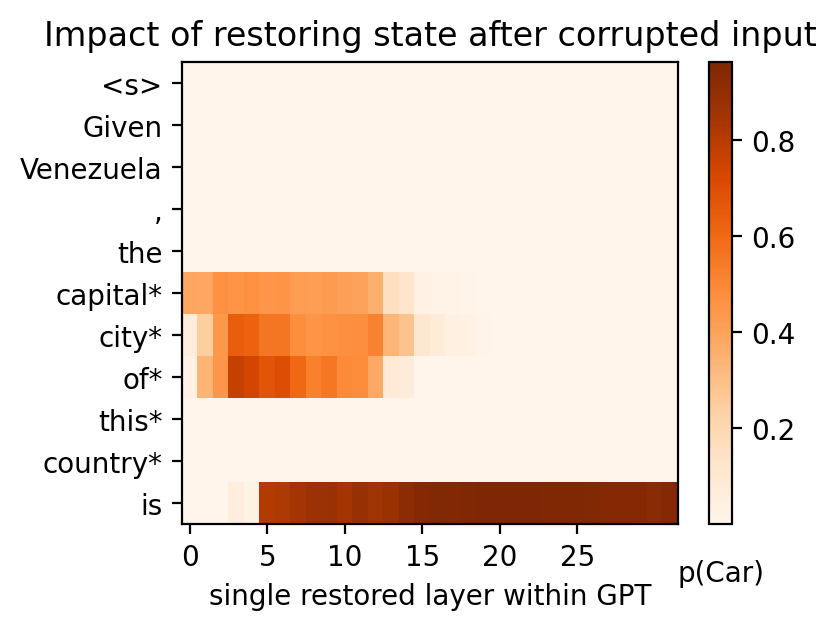

--------------------------------------------------
Plotting hs...
inp_ids=tensor([    1, 12628, 25307, 28725,   272,  5565,  2990,   302,   456,  2939,
          349], device='cuda:0')
inp_tokens: {0: '<s>', 1: '▁Given', 2: '▁Venezuela', 3: ',', 4: '▁the', 5: '▁capital', 6: '▁city', 7: '▁of', 8: '▁this', 9: '▁country', 10: '▁is'}
Answer is Car, Answer_id is 2364, Answer_token: ['▁Car'], base_score is 0.9435414671897888
noise_range : [2, 3]
Tracing 0/11 ,0/32
Tracing 0/11 ,1/32
Tracing 0/11 ,2/32
Tracing 0/11 ,3/32
Tracing 0/11 ,4/32
Tracing 0/11 ,5/32
Tracing 0/11 ,6/32
Tracing 0/11 ,7/32
Tracing 0/11 ,8/32
Tracing 0/11 ,9/32
Tracing 0/11 ,10/32
Tracing 0/11 ,11/32
Tracing 0/11 ,12/32
Tracing 0/11 ,13/32
Tracing 0/11 ,14/32
Tracing 0/11 ,15/32
Tracing 0/11 ,16/32
Tracing 0/11 ,17/32
Tracing 0/11 ,18/32
Tracing 0/11 ,19/32
Tracing 0/11 ,20/32
Tracing 0/11 ,21/32
Tracing 0/11 ,22/32
Tracing 0/11 ,23/32
Tracing 0/11 ,24/32
Tracing 0/11 ,25/32
Tracing 0/11 ,26/32
Tracing 0/11 ,27/32
Tracin

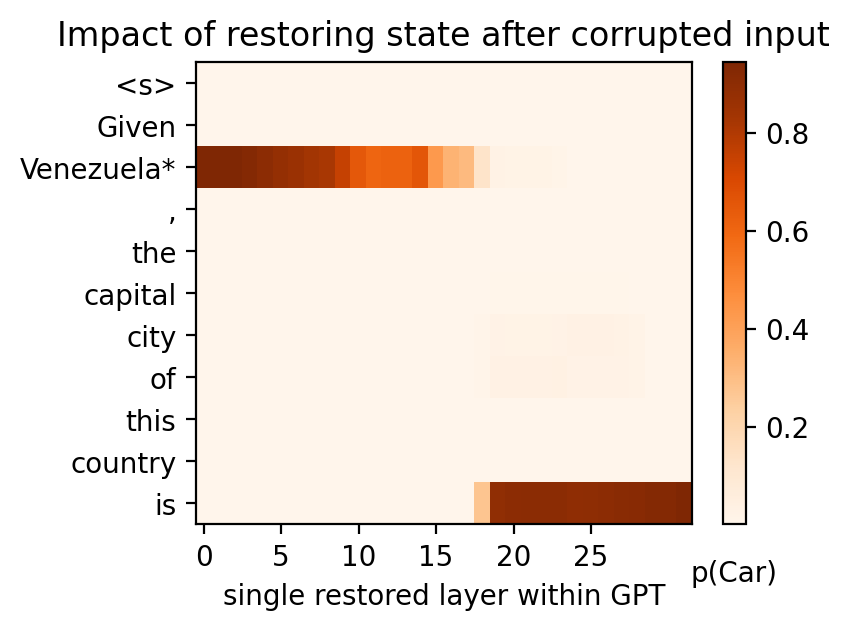

In [5]:
Recall_prompt = Template.format(subject)
token_range_sub = find_token_range(mt.tokenizer, Recall_prompt, subject)
token_range_rel = find_token_range(mt.tokenizer, Recall_prompt, relation)
# token_range_rel[1] = token_range_rel[1] + 3

res_dict_no_rel = plot_all_flow(mt, Recall_prompt, subject = None, noise = 1, type = None, noise_range = token_range_rel)
print("--------------------------------------------------")
res_dict_no_sub  = plot_all_flow(mt, Recall_prompt, subject = None, noise = 1, type = None, noise_range = token_range_sub)


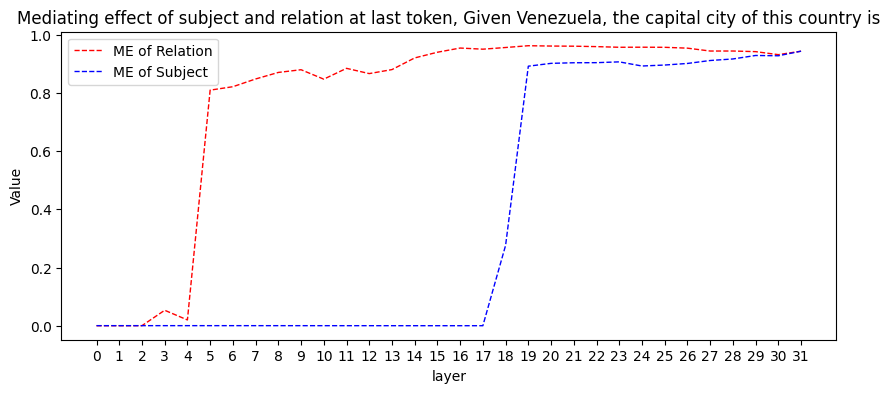

In [6]:
score_no_rel = res_dict_no_rel["hs"]['scores'][-1]
score_no_sub = res_dict_no_sub["hs"]['scores'][-1]
# score_no_instructs.append(score_no_instruct)
# score_no_inputs.append(score_no_input)
title = f"Mediating effect of subject and relation at last token, {Recall_prompt}"
plot_scores(score_no_rel, score_no_sub, title)

In [7]:
diff = torch.abs(score_no_rel - score_no_sub)
threshold = 0.4
big_diff_mask = diff > threshold
start_idx = torch.where(big_diff_mask)[0][0] if torch.any(big_diff_mask) else None
end_idx = torch.where(big_diff_mask)[0][-1]  if torch.any(big_diff_mask) else None
Range = (int(start_idx), int(end_idx))
if start_idx is None or end_idx is None:
    print("No Relation Emergence Stage Found (diff > threshold)!")
else:
    print(f"Relation Emergence Stage: {Range}")

Relation Emergence Stage: (5, 18)


## Zero shot

In [8]:
from util.locating_extracting import zero_shot, edit

In [9]:
acc_zs, acc_full, good_cases = zero_shot(mt, data_path, Recall_prompt, layer_range = Range)

subject:United States,object:Washington D.C.
Input:Given Norfolk Island,
progress:0/253
Sub: Norfolk Island
Result_ZS:True, ZS Obj: Kingston.</s></s></s>, True Obj: Kingston
Result_Full:True, Full Obj: Kingston. The official language, True Obj: Kingston
acc_zs:0.003952569169960474, acc_full:0.003952569169960474
--------------------------------------------------------------
Input:Given Kenya,
progress:1/253
Sub: Kenya
Result_ZS:True, ZS Obj: Nairobi.

, True Obj: Nairobi
Result_Full:True, Full Obj: Nairobi. Nairo, True Obj: Nairobi
acc_zs:0.007905138339920948, acc_full:0.007905138339920948
--------------------------------------------------------------
Input:Given Abkhazia,
progress:2/253
Sub: Abkhazia
Result_ZS:False, ZS Obj: Tbilisi.

, True Obj: Sukhumi
Result_Full:True, Full Obj: Sukhumi.</s></s>, True Obj: Sukhumi
acc_zs:0.007905138339920948, acc_full:0.011857707509881422
--------------------------------------------------------------
Input:Given Luxembourg,
progress:3/253
Sub: Luxem

In [10]:
import pickle
goog_cases_path = "good_cases_{}.pkl".format(data["name"])
with open(goog_cases_path , 'wb') as f:
    pickle.dump(good_cases, f)


In [11]:
good_data = pickle.load(open(goog_cases_path, "rb"))
print(good_data)
print(len(good_data))

[{'Subject': 'Norfolk Island', 'Predict_Obj': 'Kingston. The official language', 'True_Obj': 'Kingston'}, {'Subject': 'Kenya', 'Predict_Obj': 'Nairobi. Nairo', 'True_Obj': 'Nairobi'}, {'Subject': 'Abkhazia', 'Predict_Obj': 'Sukhumi.</s></s>', 'True_Obj': 'Sukhumi'}, {'Subject': 'Luxembourg', 'Predict_Obj': 'Luxembourg City. It is', 'True_Obj': 'Luxembourg'}, {'Subject': 'Saudi Arabia', 'Predict_Obj': 'Riyadh. R', 'True_Obj': 'Riyadh'}, {'Subject': 'Canada', 'Predict_Obj': 'Ottawa.</s></s></s>', 'True_Obj': 'Ottawa'}, {'Subject': 'Morocco', 'Predict_Obj': 'Rabat. This city is', 'True_Obj': 'Rabat'}, {'Subject': 'Aruba', 'Predict_Obj': 'Oranjestad.\n', 'True_Obj': 'Oranjestad'}, {'Subject': 'Greenland', 'Predict_Obj': 'Nuuk. It is located', 'True_Obj': 'Nuuk'}, {'Subject': 'Bosnia and Herzegovina', 'Predict_Obj': 'Sarajevo. This', 'True_Obj': 'Sarajevo'}, {'Subject': 'Wales', 'Predict_Obj': 'Cardiff. This city is', 'True_Obj': 'Cardiff'}, {'Subject': 'Lebanon', 'Predict_Obj': 'Beirut. Be

In [12]:
acc = edit(mt, good_data, Recall_prompt, relation, layer_range = Range)

Input: What is the depth of Norfolk Island?
Input_modify: What is the depth of Norfolk Island? Actually, I am asking its capital city of this country
progress:0/231
Sub: Norfolk Island
Result:False
 Edit_Obj: Kingstown.</s></s>, Modify_obj: .

## Answer (, True_Obj: Kingston
acc:0.0, acc_modify:0.0
--------------------------------------------------------------
Input: What is the adaptation of Kenya?
Input_modify: What is the adaptation of Kenya? Actually, I am asking its capital city of this country
progress:1/231
Sub: Kenya
Result:True
 Edit_Obj: Nairobi.</s></s>, Modify_obj: .

## Answer (, True_Obj: Nairobi
acc:0.004329004329004329, acc_modify:0.0
--------------------------------------------------------------
Input: What is the solubility of Abkhazia?
Input_modify: What is the solubility of Abkhazia? Actually, I am asking its capital city of this country
progress:2/231
Sub: Abkhazia
Result:False
 Edit_Obj: Tbilisi?

, Modify_obj: .

Comment: I, True_Obj: Sukhumi
acc:0.00432900432900